Load sample

In [14]:
import torch
from src.datasets.base_dataset import dataset_globber
from src.datasets.downsample_dataset import DownsampleMaskDataset
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

config: dict[str, int | str | list | float] = {
    "batch_size": 1,
    "target_level": 3,
    "num_workers": 9,
    "seed": 42,
    "base_dir": "/data2/projects/DigiStrudMed_sklein/",
    "data_split": [0.8, 0.15, 0.05],
    "annos_of_interest": [
        "Tissue",
        "Tumor_vital",
        "Angioinvasion",
        "Tumor_necrosis",
        "Tumor_regression",
    ],
}

level: int = int(config["target_level"])
config["cache_path"] = (
    config["base_dir"]
    + f"downsampled_datasets/cached_DownsampleDataset_level_{level}.json"
)

input_dicts = dataset_globber(
    config["base_dir"] + "DigiStrucMed_Braesen/all_data/",
    config["base_dir"] + "survival_status.csv",
)
img_transform = transforms.Compose(
    [
        # transforms.ColorJitter(
        #     brightness=0.1, contrast=0.1, saturation=0.05, hue=0.01
        # ),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

stack_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
    ]
)

dataset: DownsampleMaskDataset = DownsampleMaskDataset(
    input_dicts,
    foreground_key="Tissue",
    image_key="image",
    label_key="surv_days",
    keys=config["annos_of_interest"],
    censor_key="uncensored",
    json_key="geojson",
    cache=True,
    cache_file=config["cache_path"],
    target_level=3,
    transform1=img_transform,
    # transform2=stack_transform,
)
image = dataset[0]["data"]


Cache: True
Cache file: /data2/projects/DigiStrudMed_sklein/downsampled_datasets/cached_DownsampleDataset_level_3.json
Found cached Dataset at /data2/projects/DigiStrudMed_sklein/downsampled_datasets/cached_DownsampleDataset_level_3.json


INFO:StdOut:Found cached Dataset at /data2/projects/DigiStrudMed_sklein/downsampled_datasets/cached_DownsampleDataset_level_3.json
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.


Draw stuff

In [15]:
from src.networks.pathology import CoxEffNet, CoxResNet
from src.networks.genomic import SNNet
from src.networks.fusion import MultiSurv
from src.networks.kronecker_attention import KroneckerFusion
from src.networks.embrace import EmbraceNet
from src.networks.attention import Attention

from torchview import draw_graph


In [16]:
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
# graphviz.set_jupyter_format('png')

DEBUG:graphviz._tools:os.makedirs('../assets/networks')
DEBUG:graphviz.saving:write lines to '../assets/networks/CosResNet.gv'
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tpng', '-O', 'CosResNet.gv']
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tsvg']


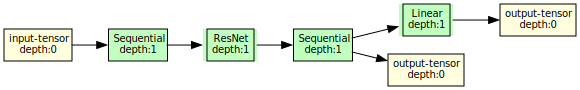

In [17]:
coxres_model = CoxResNet(
    input_channels=8,
    feature_size=1000,
)
cox_graph = draw_graph(
    model=coxres_model,
    input_data=image.unsqueeze(0),
    graph_name="CosResNet",
    depth=1,
    device="cpu",
    mode="eval",
    expand_nested=True,
    graph_dir="LR",
    show_shapes=False,
    strict=False,
    save_graph=True,
    directory="../assets/networks",
)
cox_graph.visual_graph

/home/sklein/mambaforge/envs/sklein/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
DEBUG:graphviz._tools:os.makedirs('../assets/networks')
DEBUG:graphviz.saving:write lines to '../assets/networks/CoxEffNet.gv'
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tpng', '-O', 'CoxEffNet.gv']
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tsvg']


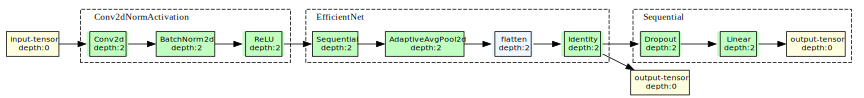

In [18]:
coxeff_model = CoxEffNet(
    input_channels=8,
    feature_size=1000,
)
cox2_graph = draw_graph(
    model=coxeff_model,
    input_data=image.unsqueeze(0),
    graph_name="CoxEffNet",
    depth=2,
    device="cpu",
    mode="eval",
    expand_nested=True,
    graph_dir="LR",
    show_shapes=False,
    strict=False,
    save_graph=True,
    directory="../assets/networks/",
)
cox2_graph.visual_graph


DEBUG:graphviz._tools:os.makedirs('../assets/networks')
DEBUG:graphviz.saving:write lines to '../assets/networks/SNNet.gv'
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tpng', '-O', 'SNNet.gv']
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tsvg']


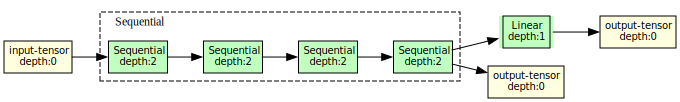

In [19]:
genetic = torch.rand([1, 750])
sn_model = SNNet(input_dim=750, feature_size=1000, elu=False, init_max=False, dropout_rate=0.25)
sn_graph = draw_graph(
    model=sn_model,
    input_data=genetic,
    graph_name="SNNet",
    depth=2,
    device="cpu",
    mode="eval",
    expand_nested=True,
    graph_dir="LR",
    show_shapes=False,
    strict=False,
    save_graph=True,
    directory="../assets/networks/",
)
sn_graph.visual_graph


Multisurv

TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
DEBUG:graphviz._tools:os.makedirs('../assets/networks')
DEBUG:graphviz.saving:write lines to '../assets/networks/Mutlisurv.gv'
DEBUG:graphviz.backend.execute:run [P

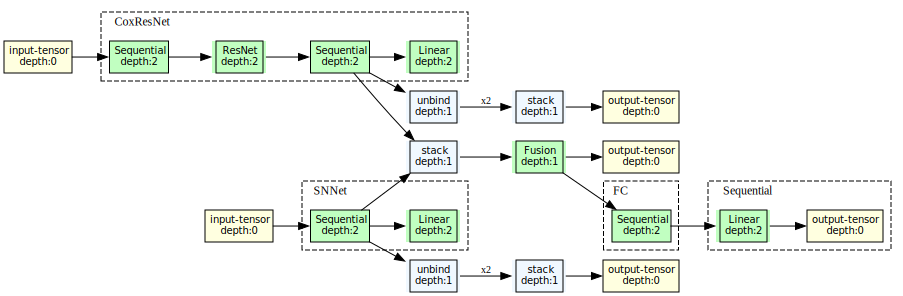

In [20]:
from src.datasets.nested_dataset import MultimodalDataset
fusion_model = MultiSurv(
    [
        "wsi",
        "rcc",
    ],
)

mm_dataset = MultimodalDataset(
    dataset,
    rcc_path="/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/NanoString_RCC/",
    surv_path="/data2/projects/DigiStrudMed_sklein/survival_status.csv",
    # "/media/sciobiome/DATA/sklein_tmp/DigiStrucMed_Braesen/NanoString_RCC/",
    # "/media/sciobiome/DATA/sklein_tmp/survival_status.csv",
)
batch = next(iter(DataLoader(mm_dataset, batch_size=2)))
multisurv_graph = draw_graph(
    model=fusion_model,
    input_data=[batch[0]], # batch[0] is a dict, we need to wrap it in a list to prevent unpacking
    graph_name="Mutlisurv",
    depth=2,
    device="cpu",
    mode="eval",
    expand_nested=True,
    graph_dir="LR",
    show_shapes=False,
    strict=True,
    save_graph=True,
    directory="../assets/networks/",
)
multisurv_graph.visual_graph


Kronecker

DEBUG:graphviz._tools:os.makedirs('../assets/networks')
DEBUG:graphviz.saving:write lines to '../assets/networks/Kronecker.gv'
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tpng', '-O', 'Kronecker.gv']
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tsvg']


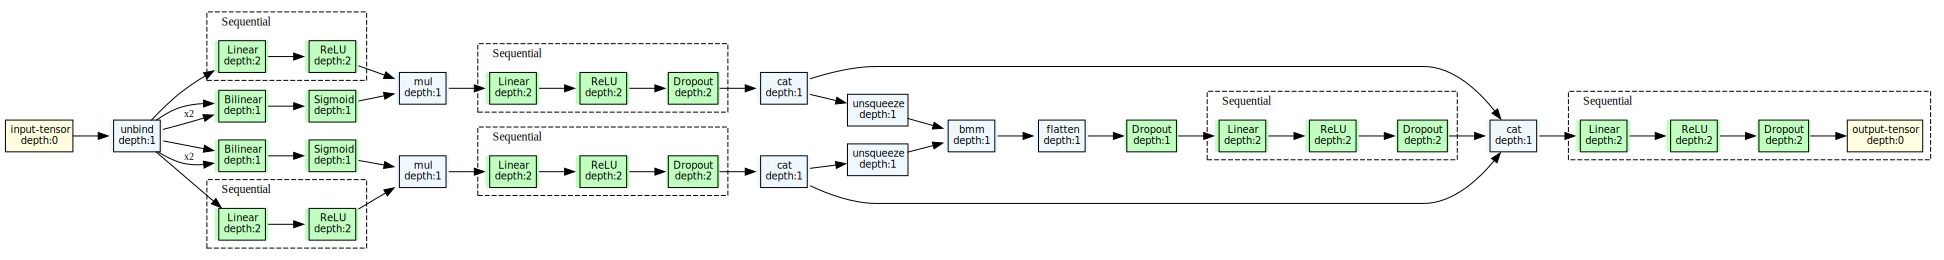

In [21]:
feature = torch.rand([1, 1000])


kronecker_model = KroneckerFusion(
    dim1=1000,
    scale_dim1=4,
    dim2=1000,
    scale_dim2=4,
    feature_size=1000,
)


kronecker_graph = draw_graph(
    model=kronecker_model,
    input_data=torch.stack([feature, feature]),
    graph_name="Kronecker",
    depth=3,
    device="cpu",
    mode="eval",
    expand_nested=True,
    graph_dir="LR",
    show_shapes=False,
    strict=False,
    save_graph=True,
    directory="../assets/networks/",
)
kronecker_graph.visual_graph

DEBUG:graphviz._tools:os.makedirs('../assets/networks')
DEBUG:graphviz.saving:write lines to '../assets/networks/Attention.gv'
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tpng', '-O', 'Attention.gv']
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tsvg']


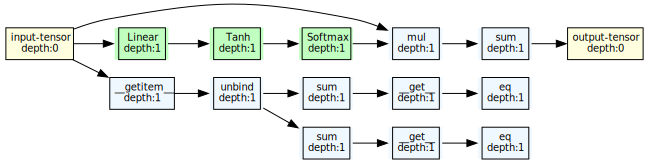

In [22]:
attention_model = Attention(size=1000)

attention_graph = draw_graph(
    model=attention_model,
    input_data=torch.stack([feature, feature]),
    graph_name="Attention",
    depth=1,
    device="cpu",
    mode="eval",
    expand_nested=True,
    graph_dir="LR",
    show_shapes=False,
    strict=False,
    save_graph=True,
    directory="../assets/networks/",
)
attention_graph.visual_graph

EmbraceNet

In [23]:
x = torch.stack([feature, feature])
m, b, c = x.size()
m, b, c

(2, 1, 1000)

In [24]:
p = torch.ones(x.size(0), b)  # Size modalities x batch

# Handle missing data
for i, modality in enumerate(x):
    for j, batch_element in enumerate(modality):
        if len(torch.nonzero(batch_element)) < 1:
            p[i, j] = 0

# Equal chances to all available modalities in each mini batch element
m_vector = torch.sum(p, dim=0)
p /= m_vector

In [25]:
r = torch.multinomial(
    input=p.transpose(0, 1), num_samples=c, replacement=True)
r = torch.nn.functional.one_hot(r.long(), num_classes=m)
r = r.permute(2, 0, 1)

DEBUG:graphviz._tools:os.makedirs('../assets/networks')
DEBUG:graphviz.saving:write lines to '../assets/networks/EmbraceNet.gv'
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tpng', '-O', 'EmbraceNet.gv']
DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tsvg']


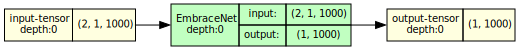

In [26]:
embrace_model = EmbraceNet(device='cpu')
embrace_graph = draw_graph(
    model=embrace_model,
    input_data=torch.stack([feature, feature]),
    graph_name="EmbraceNet",
    depth=10,
    device="cpu",
    mode="eval",
    expand_nested=True,
    graph_dir="LR",
    show_shapes=True,
    strict=False,
    save_graph=True,
    directory="../assets/networks/",
)
embrace_graph.visual_graph